In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import fish_proc.wholeBrainDask.cellProcessing_single_WS as fwc
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190907/fish00/7dpf_HuC-GC7FF_GU-fwd_fish00_exp01_20190907_172639/'
import dask.array as da

In [2]:
brain_map = np.load(save_root+'Y_ave.npy')

In [3]:
_ = np.load(save_root+'cell_dff.npz', allow_pickle=True)
A = _['A']
dFF = _['dFF']
A_loc = _['A_loc']
_ = None

# plt.figure(figsize=(20, 3))
# plt.plot(dFF[10000])

In [6]:
dset_dir = '/nrs/ahrens/jing/state_modulation/LG_vs_NGGU/20190907/fish00/7dpf_HuC-GC7FF_GU-fwd_fish00_exp01_20190907_172639/'
processed_dir = dset_dir + 'processed/'
im_dir = dset_dir + 'im/'
CL_path = processed_dir + 'CL_trials.pkl'
OL_path = processed_dir + 'OL_trials.pkl'

In [7]:
import pandas as pd

CL_trials = pd.read_pickle(CL_path)
OL_trials = pd.read_pickle(OL_path)
trial_list = [CL_trials, OL_trials]

In [8]:
def ep2frame(camtrig, thres=3.8):
    arr_ = (camtrig>thres).astype('int')
    return np.where((arr_[:-1]-arr_[1:])==-1)[0]+1

In [9]:
epoch_list = []
trial_type = []
time_list = []
for n, _ in enumerate(trial_list):
    for ntrial in range(len(_)):
        epoch_ = _.iloc[ntrial]['epoch_im2ep']
        indx = ep2frame(_.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
        trial_type.append(n)
        epoch_list.append(epoch_[indx])
        time_list.append(_.iloc[ntrial]['ds_trial_inds'])

## Open loop vs close loop difference cells

In [10]:
# from scipy.stats import ranksums
# len_ = len(trial_type)
# max_t = np.array([len(_) for _ in time_list]).max()
# p_list = np.zeros((dFF.shape[0], 120))
# for cell_id in range(dFF.shape[0]):
#     dFF_cell = dFF[cell_id]
#     dFF_cell_list = []
#     for _ in time_list:
#         dFF_cell_list.append(dFF_cell[_])
#     dFF_mat = np.zeros((len_, max_t))
#     dFF_mat[:] = np.nan
#     for n_ in range(len_):
#         n = trial_type[n_]
#         valid_ = (epoch_list[n_]>=(n*5)) & (epoch_list[n_]<(n*5+5))
#         t_ = valid_.sum()
#         dFF_mat[n_, :t_] = dFF_cell_list[n_][valid_]
#     for ntime in range(120):
#         _, p = ranksums(dFF_mat[np.array(trial_type)==0, ntime], dFF_mat[np.array(trial_type)==1, ntime])
#         p_list[cell_id, ntime] = p
# np.save(save_root+'p_value', p_list)

In [11]:
p_list = np.load(save_root+'p_value.npy')

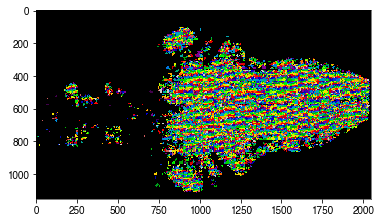

In [12]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(A):
    if (p_list[n_, 20:]<0.05).mean()<0.2:
        continue
    A_loc_ = A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()

_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [13]:
sub_indx = (p_list[:, 20:]<0.05).mean(axis=-1)>0.2
print(f'number of cell segments in analysis: {sub_indx.sum()}')

number of cell segments in analysis: 43324


In [14]:
dFF_ave = dFF[sub_indx].mean(axis=0)

In [15]:
len_ = len(trial_type)
max_t = np.array([len(_) for _ in time_list]).max()
dFF_cell_list = []
for _ in time_list:
    dFF_cell_list.append(dFF_ave[_])
dFF_mat = np.zeros((len_, max_t))
dFF_mat[:] = np.nan
for n_ in range(len_):
    n = trial_type[n_]
    valid_ = (epoch_list[n_]>=(n*5)) & (epoch_list[n_]<(n*5+5))
    t_ = valid_.sum()
    dFF_mat[n_, :t_] = dFF_cell_list[n_][valid_]

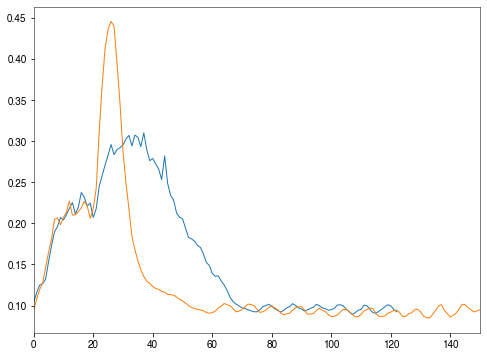

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==0].mean(axis=0))
plt.plot(dFF_mat[np.array(trial_type)==1].mean(axis=0))
plt.xlim([0, 150])
plt.show()

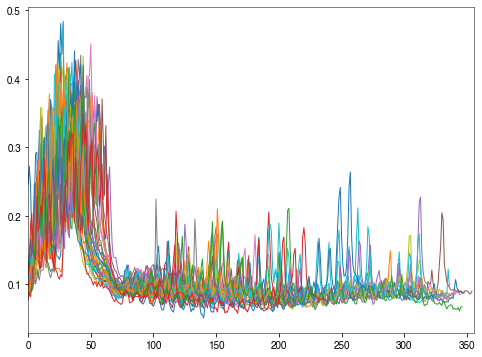

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==0].T)
plt.xlim([0, max_t])
plt.show()

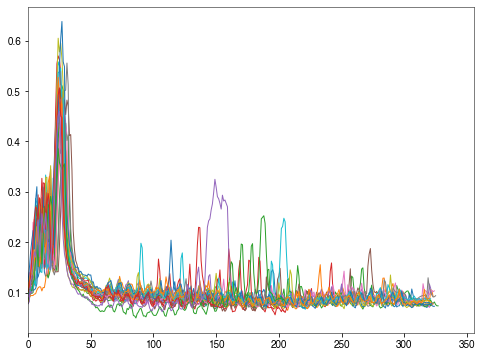

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(dFF_mat[np.array(trial_type)==1].T)
plt.xlim([0, max_t])
plt.show()

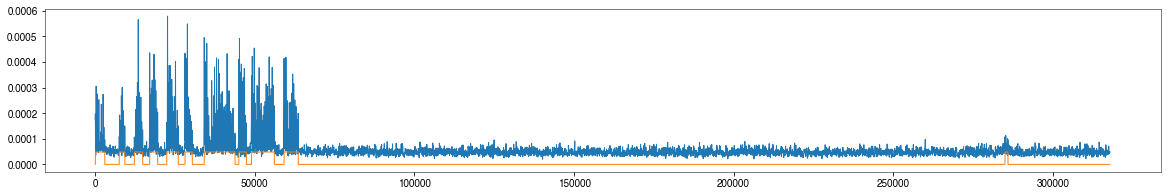

In [19]:
plt.figure(figsize=(20, 3))
plt.plot(CL_trials.iloc[0]['swimpower_im2ep'])
plt.plot(CL_trials.iloc[0]['swimming_im2ep']*np.median(CL_trials.iloc[0]['swimpower_im2ep']))
plt.show()

In [20]:
swim_power = CL_trials.iloc[0]['swimpower_im2ep']

In [21]:
indx = ep2frame(CL_trials.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
swim_power_frame = [swim_power[indx[n]:indx[n+1]].mean() for n in range(len(indx)-1)]
swim_power_frame.append(min(swim_power_frame))
swim_power_frame = np.array(swim_power_frame)

In [22]:
swim_power_frame.shape

(334,)

In [23]:
def frame_swim_power(swim_power, indx):
    swim_power_frame = [swim_power[indx[n]:indx[n+1]].mean() for n in range(len(indx)-1)]
    swim_power_frame.append(min(swim_power_frame))
    return np.array(swim_power_frame)

In [24]:
epoch_list = []
trial_type = []
time_list = []
pulse_probe_list = []
swim_power_list = []
for n, _ in enumerate(trial_list):
    for ntrial in range(len(_)):
        epoch_ = _.iloc[ntrial]['epoch_im2ep']
        swim_power = _.iloc[ntrial]['swimpower_im2ep']
        indx = ep2frame(_.iloc[ntrial]['camtrig_im2ep'], thres=3.8)
        pulse_ = _.iloc[ntrial]['cmdvel_im2ep'][indx]
        trial_type.append(n)
        epoch_list.append(epoch_[indx])
        time_list.append(_.iloc[ntrial]['ds_trial_inds'])
        pulse_probe_list.append((pulse_==pulse_.max())&(epoch_[indx]==(n*5+3)))
        swim_power_list.append(frame_swim_power(swim_power, indx))

In [25]:
(np.array(trial_type)==0).sum()

34

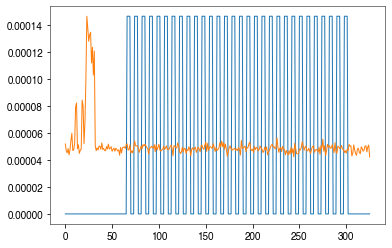

In [27]:
n_ = 34
plt.plot((pulse_probe_list[n_]).astype('float')*swim_power_list[n_].max())
plt.plot(swim_power_list[n_])
plt.savefig('tmp.pdf')

## Pulse neurons with activity different in CL vs OL

In [28]:
sig_cell_dFF = dFF[sub_indx]
sig_cell_A = A[sub_indx]
sig_cell_A_loc = A_loc[sub_indx]
sig_cell_num = sig_cell_dFF.shape[0]

In [29]:
from scipy.stats import ranksums

In [30]:
pulse_cell = np.zeros((sig_cell_num, len(trial_type)))

for n_ in range(sig_cell_num):
    dFF_cell = sig_cell_dFF[n_]
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        pulse_ = pulse_probe_list[m][epoch_==(trial_type[m]*5+3)]
        dFF_trial = dFF_cell[_][epoch_==(trial_type[m]*5+3)]
        _, p = ranksums(dFF_trial[pulse_==0], dFF_trial[pulse_==1])
        pulse_cell[n_, m] = p

In [31]:
pulse_indx = (pulse_cell<0.05).mean(axis=-1)>0.6

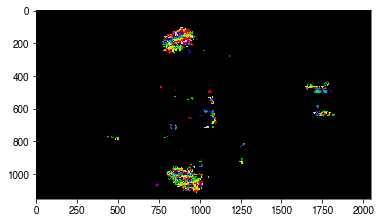

In [32]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(sig_cell_A):
    if not pulse_indx[n_]:
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     if (_>0).sum()==0:
#         continue
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()
_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [33]:
cell_act_CL = np.zeros((pulse_indx.sum(), 400))
cell_act_OL = np.zeros((pulse_indx.sum(), 400))
for n_, dFF_cell in enumerate(sig_cell_dFF[pulse_indx]):
    dFF_trial = np.zeros((len(time_list), 400))
    dFF_trial[:] = np.nan
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        indx_ = epoch_==(trial_type[m]*5+3)
        t_ = indx_.sum()
        dFF_trial[m, :t_] = dFF_cell[_][indx_]
    cell_act_CL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==0, :], axis=0)
    cell_act_OL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==1, :], axis=0)

In [58]:
import seaborn as sns
sns.set_style('ticks')

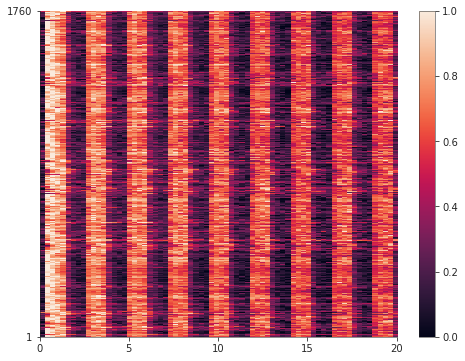

In [59]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_CL[:, :240]/cell_act_CL[:, :240].max(axis=-1, keepdims=True), aspect='auto', extent=(0, 240/3.5,1, cell_act_CL.shape[0]), vmax=1, vmin=0)
plt.yticks([1, cell_act_CL.shape[0]])
plt.xticks(np.arange(0, 25, 5))
plt.xlim([0, 20])
plt.colorbar()
sns.despine()
plt.savefig('tmp1.pdf')

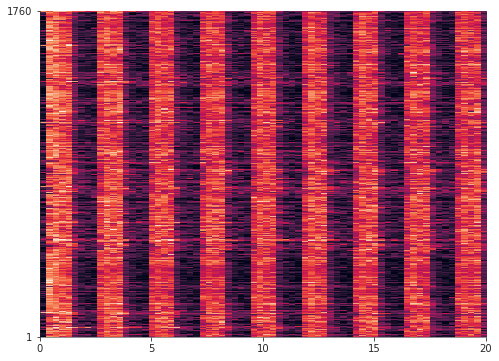

In [61]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_OL[:, :240]/cell_act_CL[:, :240].max(axis=-1, keepdims=True), aspect='auto', extent=(0, 240/3.5,1, cell_act_CL.shape[0]), vmax=1, vmin=0)
plt.yticks([1, cell_act_CL.shape[0]])
plt.xticks(np.arange(0, 25, 5))
plt.xlim([0, 20])
sns.despine()
plt.savefig('tmp2.pdf')

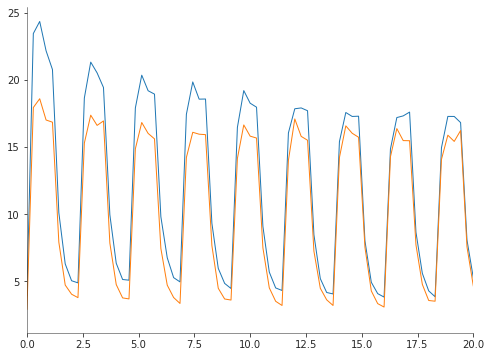

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(240)/3.5, cell_act_CL[:, :240].mean(axis=0)*100)
plt.plot(np.arange(240)/3.5, cell_act_OL[:, :240].mean(axis=0)*100)
plt.xlim([0, 20])
sns.despine()
plt.savefig('tmp3.pdf')

## Motor neurons with activity different in CL vs OL

In [286]:
motor_cell = np.zeros((sig_cell_num, 70))

for n_ in range(sig_cell_num):
    dFF_cell = sig_cell_dFF[n_]
    dFF_trial_list = np.zeros((len(time_list), 70))
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        motor_ = pulse_probe_list[m][epoch_==(trial_type[m]*5+1)]
        dFF_trial = dFF_cell[_][epoch_==(trial_type[m]*5+1)]
        t_len = len(dFF_trial)
        dFF_trial_list[m, :t_len] = dFF_trial
    for ntime in range(70):
        _, p = ranksums(dFF_trial_list[np.array(trial_type)==0, ntime], dFF_trial_list[np.array(trial_type)==1, ntime])
        motor_cell[n_, ntime] = p

In [289]:
motor_cell = motor_cell[:, :40]

In [325]:
motor_indx = (motor_cell<0.05).mean(axis=-1)>0.9
print(f'number of motor cell: {motor_indx.sum()}')

number of motor cell: 4681


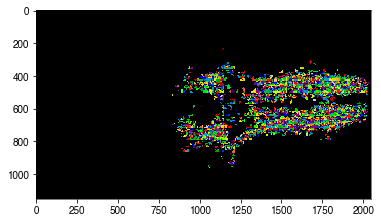

In [326]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(sig_cell_A):
    if not motor_indx[n_]:
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

# for z in range(A_ext.shape[0]):
#     _ = A_ext[z].copy()
#     if (_>0).sum()==0:
#         continue
#     _[_>0] = _[_>0]%32+1
#     plt.imshow(_, cmap=plt.cm.nipy_spectral)
#     plt.show()
_ = A_ext.max(axis=0)
_[_>0] = _[_>0]%32+1
plt.imshow(_, cmap=plt.cm.nipy_spectral)
plt.show()

In [327]:
cell_act_CL = np.zeros((motor_indx.sum(), 80))
cell_act_OL = np.zeros((motor_indx.sum(), 80))
for n_, dFF_cell in enumerate(sig_cell_dFF[motor_indx]):
    dFF_trial = np.zeros((len(time_list), 80))
    dFF_trial[:] = np.nan
    for m, _ in enumerate(time_list):
        epoch_ = epoch_list[m]
        indx_ = epoch_==(trial_type[m]*5+1)
        t_ = indx_.sum()
        dFF_trial[m, :t_] = dFF_cell[_][indx_]
    cell_act_CL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==0, :], axis=0)
    cell_act_OL[n_] = np.nanmean(dFF_trial[np.array(trial_type)==1, :], axis=0)

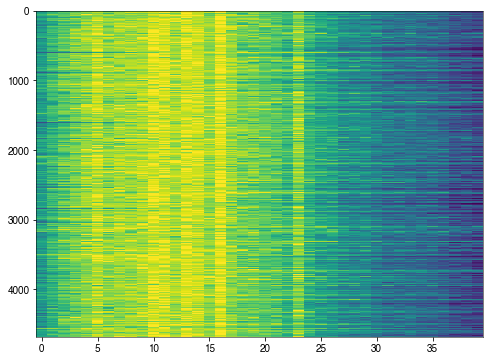

In [328]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_CL[:, :40]/cell_act_CL[:, :40].max(axis=-1, keepdims=True), aspect='auto')
plt.show()

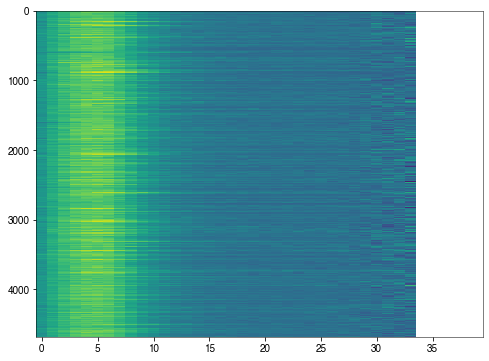

In [329]:
plt.figure(figsize=(8, 6))
plt.imshow(cell_act_OL[:, :40]/cell_act_CL[:, :40].max(axis=-1, keepdims=True), aspect='auto')
plt.show()

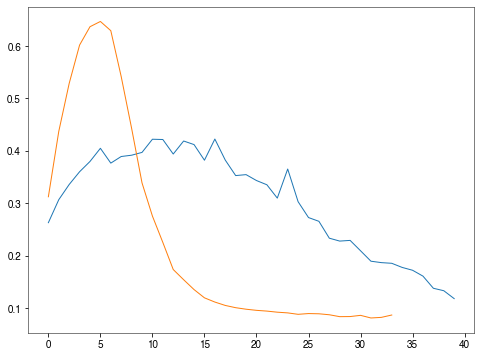

In [330]:
plt.figure(figsize=(8, 6))
plt.plot(cell_act_CL[:, :40].mean(axis=0))
plt.plot(cell_act_OL[:, :40].mean(axis=0))
plt.show()

## Overlay pulse and motor neurons

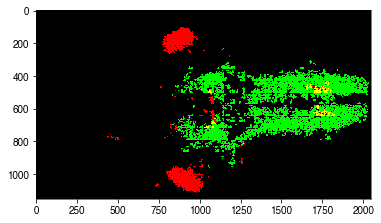

In [331]:
A_ext = np.zeros((brain_map.shape[1], brain_map.shape[2], 3))
z_ = brain_map.shape[0]
for n_, A_ in enumerate(sig_cell_A):
    if (not pulse_indx[n_]) and (not motor_indx[n_]):
        continue
    A_loc_ = sig_cell_A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.5).astype('int')
    cx, cy = A_ext[x:x+100, y:y+100, 1].shape
    if pulse_indx[n_]:
        A_ext[x:x+100, y:y+100, 0]=np.maximum(A_ext[x:x+100, y:y+100, 0], _[:cx, :cy])
    if motor_indx[n_]:
        A_ext[x:x+100, y:y+100, 1]=np.maximum(A_ext[x:x+100, y:y+100, 1], _[:cx, :cy])

plt.imshow(A_ext)
plt.show()